In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# Chargement des données 

In [2]:
train=pd.read_csv('Admission_Predict.csv')
train

,gre,sop,cgpa,admitted
0,337,4.5,9.65,1
1,324,4.0,8.87,1
2,316,3.0,8.00,1
3,322,3.5,8.67,1
4,314,2.0,8.21,0
...,...,...,...,...
395,324,3.5,9.04,1
396,325,3.0,9.11,1
397,330,5.0,9.45,1
398,312,3.5,8.78,0


In [3]:
train.sample(5)

,gre,sop,cgpa,admitted
202,340,4.5,9.91,1
50,313,2.5,8.30,1
63,315,4.0,8.50,1
360,322,4.0,8.64,1
139,318,3.5,9.12,0


In [4]:
#Renommer la colonne Admission
train.rename(columns=lambda x: x.replace('admitted', 'Admission'), inplace=True)

In [5]:
train['Admission'].value_counts()

1    219
0    181
Name: Admission, dtype: int64

In [6]:
train['Admission'].value_counts()*100/len(train)

1    54.75
0    45.25
Name: Admission, dtype: float64

# Analyse 

In [7]:
train.describe(include="all")

,gre,sop,cgpa,Admission
count,400.000000,400.000000,400.000000,400.000000
mean,316.807500,3.400000,8.598925,0.547500
std,11.473646,1.006869,0.596317,0.498362
min,290.000000,1.000000,6.800000,0.000000
25%,308.000000,2.500000,8.170000,0.000000
50%,317.000000,3.500000,8.610000,1.000000
75%,325.000000,4.000000,9.062500,1.000000
max,340.000000,5.000000,9.920000,1.000000


In [8]:
#Corrélation 
train.corr()

,gre,sop,cgpa,Admission
gre,1.000000,0.612831,0.833060,0.580391
sop,0.612831,1.000000,0.718144,0.444029
cgpa,0.833060,0.718144,1.000000,0.521654
Admission,0.580391,0.444029,0.521654,1.000000


In [9]:
train['sop'].isna().sum()

0

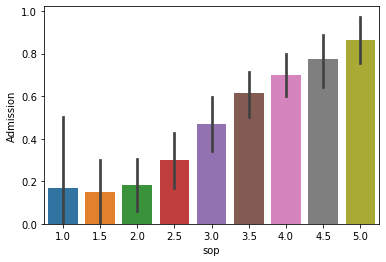

In [10]:
#Impact sop
sns.barplot(x="sop", y="Admission", data=train)

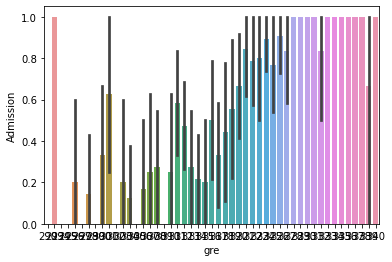

In [11]:
#impact gre
train['sop'].isna().sum()
sns.barplot(x="gre", y="Admission", data=train)

In [12]:
#Impact de gre
train['cgpa'].isna().sum()

0

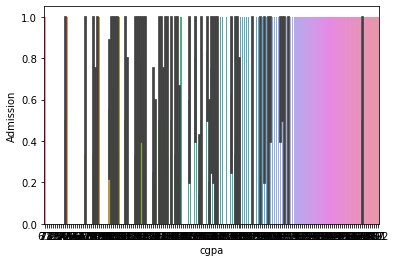

In [13]:
sns.barplot(x="cgpa", y="Admission", data=train)

In [14]:
#définir des catégories sur la colonne gre
pd.qcut(train['gre'], 6)

0      (328.0, 340.0]
1      (323.0, 328.0]
2      (312.0, 317.0]
3      (317.0, 323.0]
4      (312.0, 317.0]
            ...      
395    (323.0, 328.0]
396    (323.0, 328.0]
397    (328.0, 340.0]
398    (304.0, 312.0]
399    (328.0, 340.0]
Name: gre, Length: 400, dtype: category
Categories (6, interval[float64]): [(289.999, 304.0] < (304.0, 312.0] < (312.0, 317.0] < (317.0, 323.0] < (323.0, 328.0] < (328.0, 340.0]]

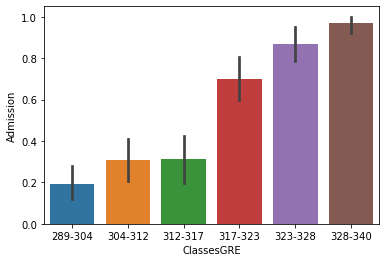

In [15]:
#classer les gre par catégories
train["gre"] = train["gre"]

bins = [289, 304, 312, 317, 323, 328, np.inf]
labels = ['289-304', '304-312', '312-317', '317-323', '323-328', '328-340']
train['ClassesGRE'] = pd.cut(train["gre"], bins, labels = labels)

#le graphe de l'admission par rapport aux classes GRE définis
sns.barplot(x="ClassesGRE", y="Admission", data=train)
plt.show()

In [16]:
#L'impact du paramètre gre est significatif, nous allons donc l'utiliser


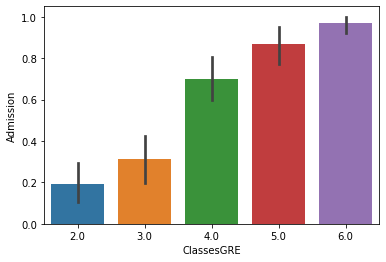

In [17]:
train['ClassesGRE']=train['ClassesGRE'].map({'289-304':1, '289-304':2, '312-317':3, '317-323':4, '323-328':5, '328-340':6})
sns.barplot(x="ClassesGRE", y="Admission", data=train)
plt.show()

In [56]:
train.sample(10)

,gre,sop,cgpa,Admission,ClassesGRE
334,312,4.5,8.65,1,NaN
90,318,4.0,7.92,1,4.0
285,331,4.0,9.26,1,6.0
273,312,1.0,8.01,1,NaN
204,298,3.5,8.54,0,2.0
125,300,2.0,8.66,1,2.0
186,317,3.5,8.68,1,3.0
331,311,3.0,8.12,1,NaN
155,312,3.0,8.69,0,NaN
249,321,3.5,8.83,1,4.0


In [57]:
index=train[train['ClassesGRE'].isna()].index
train.drop(index,0,inplace=True)
train.sample(10)

,gre,sop,cgpa,Admission,ClassesGRE
378,303,2.0,7.65,0,2.0
326,299,2.0,8.02,0,2.0
336,319,3.0,8.79,0,4.0
118,296,3.0,7.28,0,2.0
117,290,2.0,7.46,0,2.0
37,300,1.0,7.80,0,2.0
212,338,5.0,9.66,1,6.0
77,301,3.0,8.22,0,2.0
298,330,4.5,9.24,1,6.0
231,319,3.5,8.33,1,4.0


# Décomposition de l'échantillon

In [58]:
from sklearn.model_selection import train_test_split

predictors = train.drop(['Admission'], axis=1)
target = train['Admission']

Nous gardons 20 % de notre échantillon train qui est labelisé pour evaluer la performance de notre modèle

In [59]:
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.2, random_state = 0)

# Modélisation / Prédiction

In [60]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

cls=GradientBoostingClassifier().fit(x_train,y_train)
cls.score(x_val,y_val)

0.6307692307692307

In [61]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
cls=RandomForestClassifier(max_depth=12,n_estimators=300).fit(x_train,y_train)

cls.score(x_val,y_val)

0.6307692307692307

In [62]:
import pickle
# save the model to disk
filename = 'cls_Admission.pkl'
pickle.dump(cls, open(filename, 'wb'))

In [63]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val,cls.predict(x_val))

array([[15, 15],
       [ 9, 26]], dtype=int64)